In [8]:
from collections import defaultdict
import itertools 

from matplotlib import pyplot as plt
import numpy as np
from openai import OpenAI
import pandas as pd
import scipy as sp

In [20]:
def kl_divergence(p, q):
    """Takes two np.array objects containing probability distributions and computes KL divergence
    """
    
    # zero probability mass contributes zero to KL divergence (as x log (x) -> 0 as x -> 0)
    # without this, summing over log() results in nan
    p[p == 0] = 1
    q[q == 0] = 1
    
    return (p * np.log(p / q)).sum()

def l2_norm(u, v):
    return ((u - v) ** 2).sum() ** 0.5

In [10]:
df = pd.read_csv("final_data/mmlu_200_orig.csv")

In [11]:
df.head()

,question,A,B,C,D,answer,subject,question_id
0,"What is the term for commentary on the Qur'an,...",fiqh,dhikr,ijtihad,tafsir,D,world_religions_test,0
1,"In addition to Jainism, which other tradition...",Buddhism,Hinduism,Judaism,Islam,A,world_religions_test,1
2,"What is seen by Europeans, and many Muslims, a...",The Hijab,The Crescent,The Minaret,The Qur'an,B,world_religions_test,2
3,Which one of the following factors is likely t...,A model that is based on financial theory,A model that contains many variables,A model whose dependent variable has recently ...,A model that is entirely statistical in nature...,A,econometrics_test,3
4,Consider again the VAR model of equation 16. W...,The b and d coefficients significant and the a...,The a and c coefficients significant and the b...,The a and c coefficients significant,The b and d coefficients significant,D,econometrics_test,4


In [13]:
ids = df["question_id"].to_list()

In [12]:
ids

['0',
 '1',
 '2',
 '3',
 '4',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '35',
 '36',
 '37',
 '38',
 '41',
 '45',
 '46',
 '47',
 '48',
 '50',
 '51',
 '52',
 '53',
 '56',
 '57',
 '58',
 '59',
 '60',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '82',
 '83',
 '104',
 '108',
 '109',
 '112',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '146',
 '147',
 '148',
 '149',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '158',
 '161',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '175',
 '176',
 '177',
 '180',
 '181',
 '182',
 '184',
 '187',
 '188',
 '189',
 '190',
 '191',
 '192',
 '193',
 '194',
 '196',
 '197',
 '198',


In [30]:
def get_completion(model, dataset, data_id):
    with open(f"run_data/{model}/{dataset}/completion-{data_id}", "r") as f:
        return f.read()

def get_numpy_obj(model, dataset, kind, data_id):
    return np.load(f"run_data/{model}/{dataset}/{kind}-{data_id}.npy", "r").copy()

In [31]:
def collect_all_features(model, dataset_a, dataset_b, question_id):

    # first, collect completions
    completion_a = get_completion(model, dataset_a, question_id)
    completion_b = get_completion(model, dataset_b, question_id)

    # next, get distributions and compute KL-divergence
    dist_a = get_numpy_obj(model, dataset_a, "dist", question_id)
    dist_b = get_numpy_obj(model, dataset_b, "dist", question_id)
    kl_div = kl_divergence(dist_a, dist_b)

    # finally, get mean-pooled L2 norm
    state_a = get_numpy_obj(model, dataset_a, "hidden", question_id)
    state_b = get_numpy_obj(model, dataset_b, "hidden", question_id)
    l2 = l2_norm(state_a, state_b)

    return {
            "model": model,
            "question_id": question_id, 
            "dataset_a": dataset_a,
            "dataset_b": dataset_b,
            "completion_a": completion_a,
            "completion_b": completion_b,
            "KL Divergence": kl_div,
            "Euclidean Distance": l2
    }


In [6]:
dataset_pairs = [("original", "singlechar"), ("original", "reworded")]

models = ["gemma-7b-it", "Llama-2-7b-chat-hf", "Mistral-7B-Instruct-v0.2"]

In [32]:
data = []

for model in models:
    for dataset_a, dataset_b in dataset_pairs:
        for data_id in ids:
            data.append(collect_all_features(model, dataset_a, dataset_b, data_id))

In [33]:
len(data)

1200

In [35]:
results_df = pd.DataFrame(data)

In [36]:
results_df.head()

,model,question_id,dataset_a,dataset_b,completion_a,completion_b,KL Divergence,Euclidean Distance
0,gemma-7b-it,0,original,singlechar,"{\n ""answer"": ""D""\n}\n\nThe term for comment...","{\n""answer"": ""D""\n}\n\nThe ter}m for commentar...",3.344890e-05,7.834220
1,gemma-7b-it,1,original,singlechar,"{\n ""answer"": ""A""\n}\n\nBuddhism is a world-...","{\n ""answer"": ""A""\n}\n\nBuddhism began as a ...",8.689526e-05,5.159942
2,gemma-7b-it,2,original,singlechar,"{\n ""answer"": ""B""\n}\n\nThe Crescent is seen...","{\n""answer"": ""B""\n}\n\nThe Crescent is seen by...",2.117841e-05,8.370335
3,gemma-7b-it,3,original,singlechar,"{\n ""answer"": ""A""\n}\n\nA model that is base...","{\n""answer"": ""A""\n}\n\nA model that is based o...",3.192538e-04,7.458217
4,gemma-7b-it,4,original,singlechar,"{\n""answer"": ""A""\n}\n\nIn the VAR model of equ...","{\n""answer"": ""A""\n}\n\nThe VAR model #of equat...",3.273454e-08,5.714565


In [37]:
results_df.to_csv("final_data/compiled_data.csv", index=False)

## Grading

In [40]:
client = OpenAI()

In [43]:
def check_agreement(row):
    answer_a = row["completion_a"]
    answer_b = row["completion_b"]

    prompt = f"""Below are two answers to the same question. Output a '1' if the answers agree, or a '0' if the answers do not agree. Do not output anything else.

Answer 1: {answer_a}
Answer 2: {answer_b}
"""
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )
    
    return completion.choices[0].message.content.strip()
    


In [53]:
results_df["completion agreement"] = results_df.apply(check_agreement, axis=1)

In [62]:
results_df.to_csv("final_data/final_results_graded_raw.csv")

In [55]:
results_df.head(20)

,model,question_id,dataset_a,dataset_b,completion_a,completion_b,KL Divergence,Euclidean Distance,completion agreement
0,gemma-7b-it,0,original,singlechar,"{\n ""answer"": ""D""\n}\n\nThe term for comment...","{\n""answer"": ""D""\n}\n\nThe ter}m for commentar...",3.344890e-05,7.834220,1
1,gemma-7b-it,1,original,singlechar,"{\n ""answer"": ""A""\n}\n\nBuddhism is a world-...","{\n ""answer"": ""A""\n}\n\nBuddhism began as a ...",8.689526e-05,5.159942,1
2,gemma-7b-it,2,original,singlechar,"{\n ""answer"": ""B""\n}\n\nThe Crescent is seen...","{\n""answer"": ""B""\n}\n\nThe Crescent is seen by...",2.117841e-05,8.370335,1
3,gemma-7b-it,3,original,singlechar,"{\n ""answer"": ""A""\n}\n\nA model that is base...","{\n""answer"": ""A""\n}\n\nA model that is based o...",3.192538e-04,7.458217,1
4,gemma-7b-it,4,original,singlechar,"{\n""answer"": ""A""\n}\n\nIn the VAR model of equ...","{\n""answer"": ""A""\n}\n\nThe VAR model #of equat...",3.273454e-08,5.714565,1
5,gemma-7b-it,6,original,singlechar,"{\n ""answer"": ""D""\n}\n\nThe One-time pad is ...","{\n ""answer"": ""D""\n}\n\nThe One-time pad is ...",6.973096e-05,6.023392,1
6,gemma-7b-it,7,original,singlechar,"{\n ""answer"": ""B""\n}\n\nSummative evaluation...","{\n ""answer"": ""B""\n}\n\nSummative evaluation...",3.247880e-04,11.266654,1
7,gemma-7b-it,8,original,singlechar,"{\n ""answer"": ""A""\n}\n\nThe Securities Act o...","{\n ""answer"": ""A""\n}\n\nThe Securities Act o...",3.475935e-03,6.463842,1
8,gemma-7b-it,9,original,singlechar,"{\n ""answer"": ""B""\n}\n\nA baby born with pul...","{\n""answer"": ""B""\n}\n\nA baby born with pulmon...",1.259633e-04,6.149187,1
9,gemma-7b-it,10,original,singlechar,"{\n""answer"": ""B""\n}\n\nThe average number of f...","{\n""answer"": ""B""\n}\n\nThe average number of f...",1.628180e-04,3.878023,1


## Analysis

In [3]:
results_df = pd.read_csv("final_data/final_results_graded_vetted.csv")

In [4]:
dataset_pairs = [("original", "singlechar"), ("original", "reworded")]

gemma-7b-it original singlechar 190
	Agree KL Mean, SD, Support: 0.0005465437697840211, 0.0010975540374632076, 190
	Disagree KL Mean: 0.0005669582975, 0.0005463361468313908, 10
	Agree Distance Mean: 6.2176569004261015, 2.5963395578207265, 190
	Disagree Distance Mean: 9.016223368245752, 5.411422865005059, 10
	t statistic: TtestResult(statistic=-1.5430430464460942, pvalue=0.15649057356487536, df=9.198340696986204)


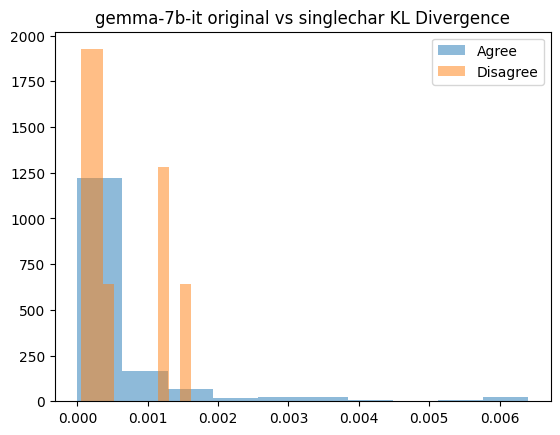

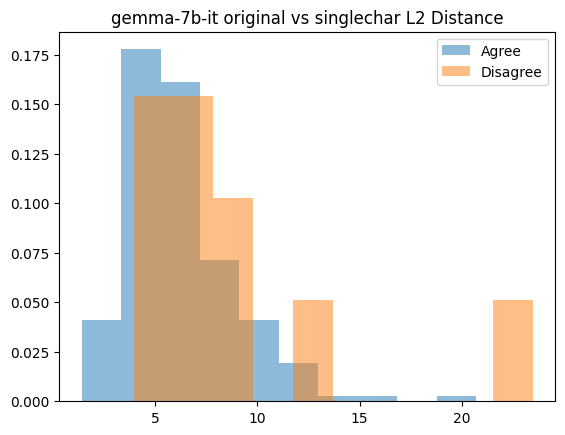

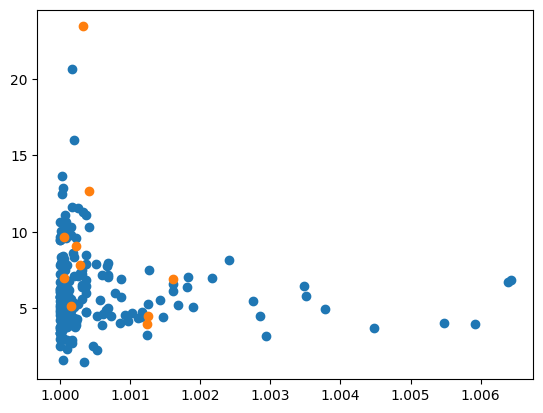

gemma-7b-it original reworded 165
	Agree KL Mean, SD, Support: 0.0012196109196019394, 0.005127884233219182, 165
	Disagree KL Mean: 0.0021554579046894284, 0.004868130535023532, 35
	Agree Distance Mean: 12.30817451578703, 4.414854738454938, 165
	Disagree Distance Mean: 14.22821436818007, 3.5275530015619077, 35
	t statistic: TtestResult(statistic=-2.757481861463025, pvalue=0.007762431796027615, df=58.39032705171524)


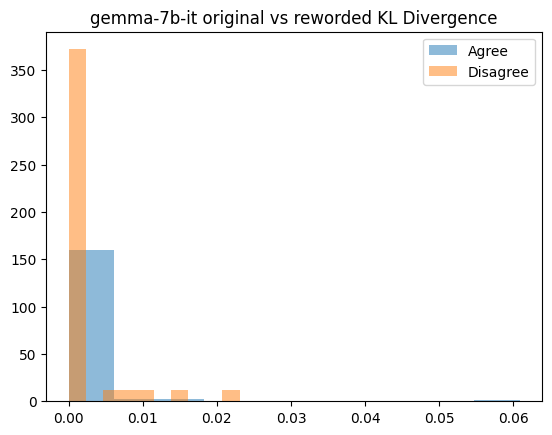

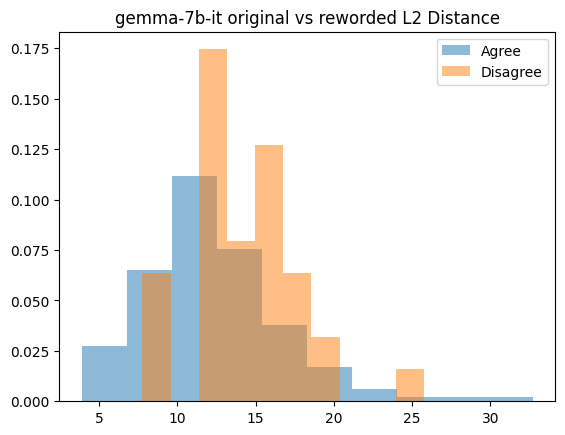

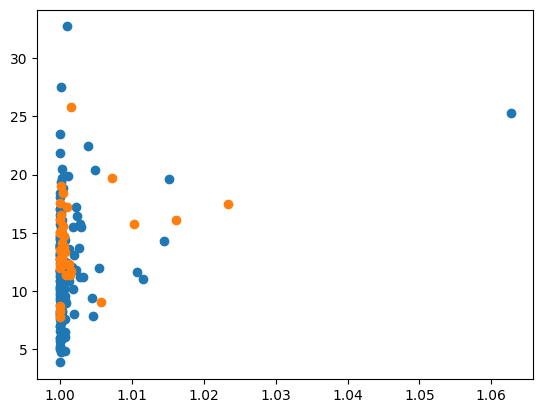

Llama-2-7b-chat-hf original singlechar 177
	Agree KL Mean, SD, Support: 1.1293015843189265e-05, 2.4990607756145136e-05, 177
	Disagree KL Mean: 5.393370866739131e-05, 0.0002191002707295492, 23
	Agree Distance Mean: 5.0469087786534255, 1.6950356708433056, 177
	Disagree Distance Mean: 5.429175221757637, 1.833862311262843, 23
	t statistic: TtestResult(statistic=-0.9293472131133829, pvalue=0.36097092584424506, df=26.911331021842525)


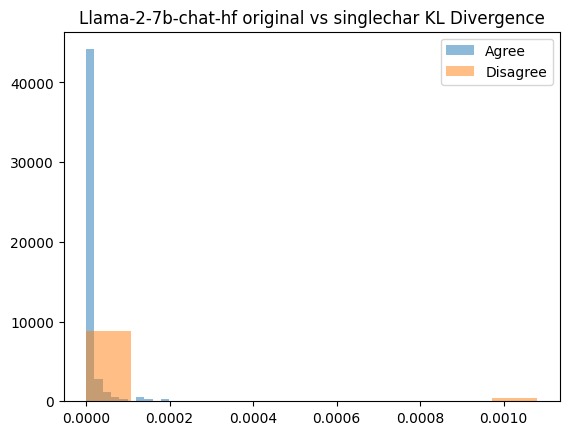

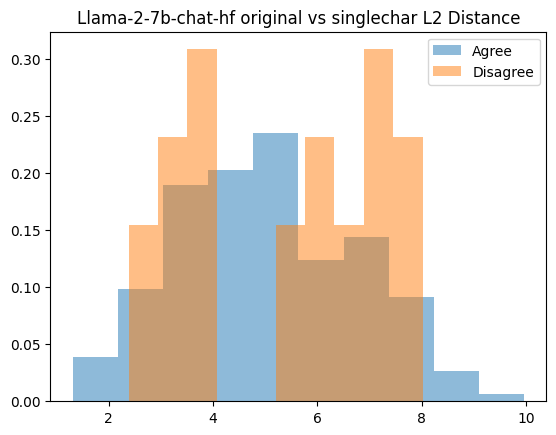

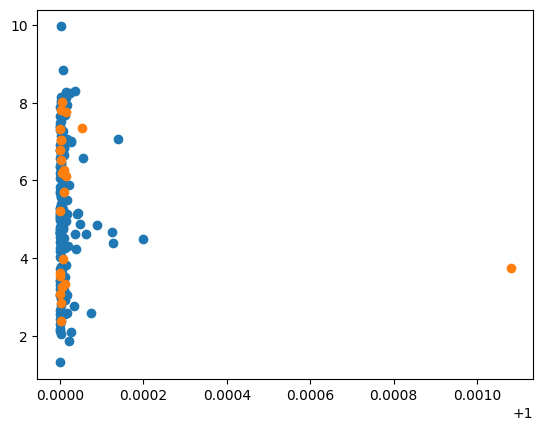

Llama-2-7b-chat-hf original reworded 150
	Agree KL Mean, SD, Support: 2.97100906574e-05, 7.103125686973202e-05, 150
	Disagree KL Mean: 2.985817837656e-05, 4.5144002231169907e-05, 50
	Agree Distance Mean: 7.052222537497789, 2.33527322418775, 150
	Disagree Distance Mean: 8.083900281412856, 2.066645830850831, 50
	t statistic: TtestResult(statistic=-2.9325545385751037, pvalue=0.004228483779592684, df=93.37623130823634)


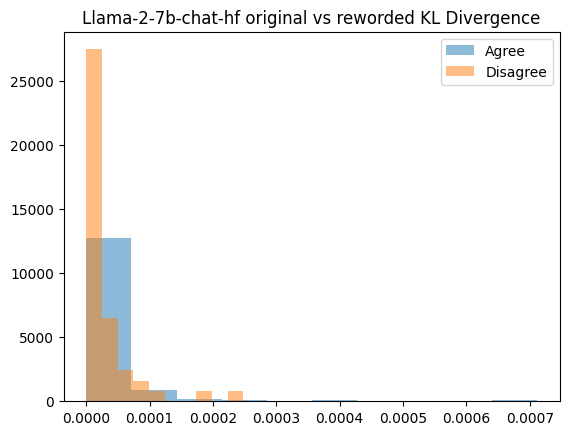

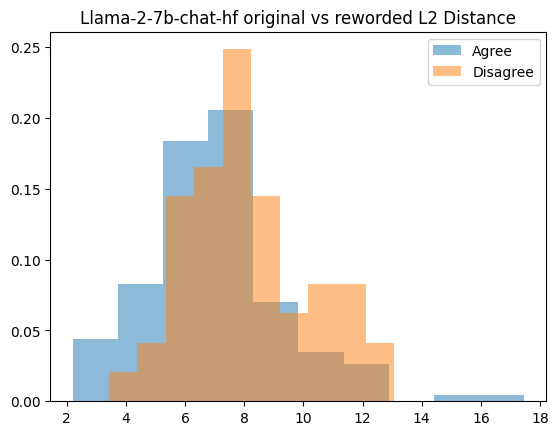

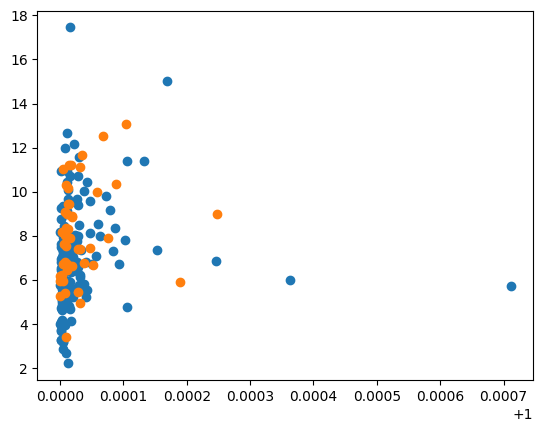

Mistral-7B-Instruct-v0.2 original singlechar 174
	Agree KL Mean, SD, Support: 0.009062248408218558, 0.04291783862889047, 174
	Disagree KL Mean: 0.06757342117556538, 0.19952005988497645, 26
	Agree Distance Mean: 13.80898530632165, 4.996960235123159, 174
	Disagree Distance Mean: 14.086111345349988, 5.666384162240921, 26
	t statistic: TtestResult(statistic=-0.23185395245020884, pvalue=0.818181149049614, df=30.878442774520845)


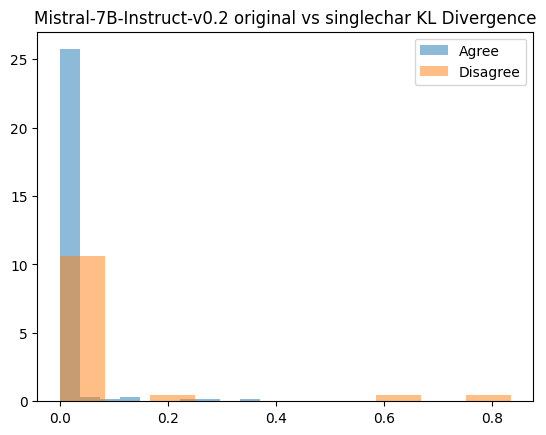

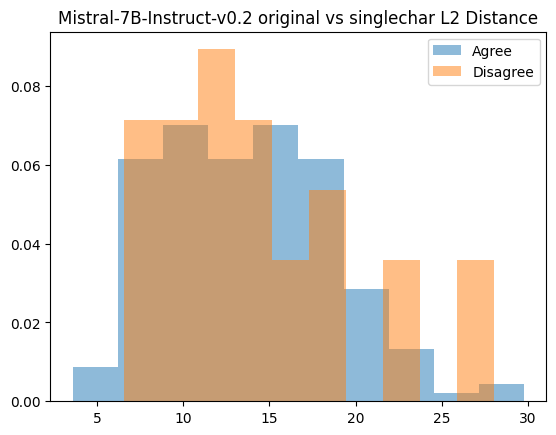

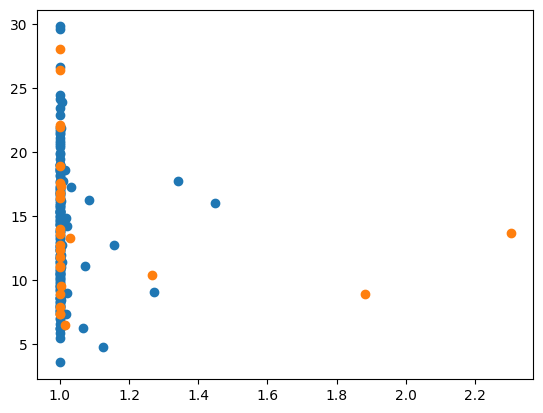

Mistral-7B-Instruct-v0.2 original reworded 151
	Agree KL Mean, SD, Support: 0.0657366936873794, 0.3236585274761409, 151
	Disagree KL Mean: 0.20330409143774283, 0.5720018691809405, 49
	Agree Distance Mean: 21.954910128181194, 7.909255407301235, 151
	Disagree Distance Mean: 24.023515406409494, 7.619677357225186, 49
	t statistic: TtestResult(statistic=-1.6219418567654913, pvalue=0.10858029523512841, df=83.62429707624942)


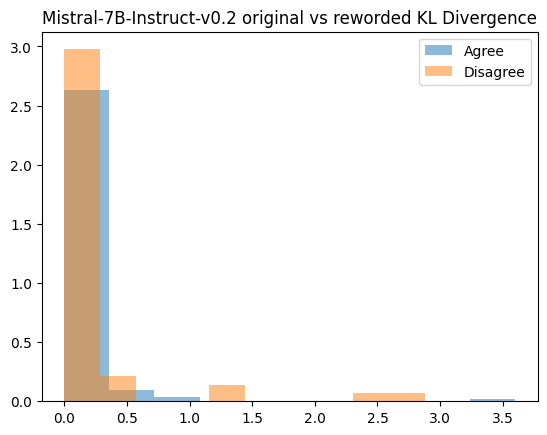

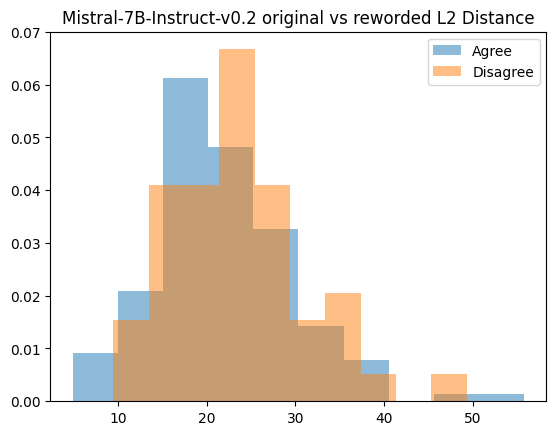

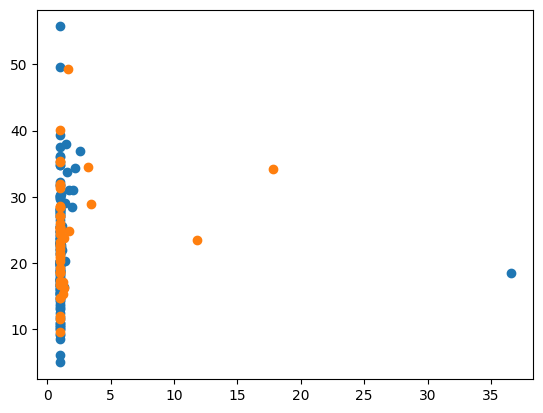

In [9]:
data = {}

for model in models:
    for dataset_a, dataset_b in dataset_pairs:
        df_slice = results_df[(results_df["model"] == model) & (results_df["dataset_a"] == dataset_a) & (results_df["dataset_b"] == dataset_b)].copy()
        df_slice["completion agreement"] = df_slice["completion agreement"].astype(int)
        print(model, dataset_a, dataset_b, df_slice["completion agreement"].sum())

        df_slice_agree = df_slice[df_slice["completion agreement"] == 1]
        df_slice_disagree = df_slice[df_slice["completion agreement"] == 0]

        agree_kl = df_slice_agree["KL Divergence"].to_numpy()
        disagree_kl = df_slice_disagree["KL Divergence"].to_numpy()

        print(f"\tAgree KL Mean, SD, Support: {agree_kl.mean()}, {agree_kl.std()}, {agree_kl.shape[0]}")
        print(f"\tDisagree KL Mean: {disagree_kl.mean()}, {disagree_kl.std()}, {disagree_kl.shape[0]}")
        agree_distance = df_slice_agree["Euclidean Distance"].to_numpy()
        disagree_distance = df_slice_disagree["Euclidean Distance"].to_numpy()

        print(f"\tAgree Distance Mean: {agree_distance.mean()}, {agree_distance.std()}, {agree_distance.shape[0]}")
        print(f"\tDisagree Distance Mean: {disagree_distance.mean()}, {disagree_distance.std()}, {disagree_distance.shape[0]}")
        print(f"\tt statistic: {sp.stats.ttest_ind(agree_distance, disagree_distance, equal_var=False)}")

        plt.hist(agree_kl, density=True, label="Agree", alpha=0.5)
        plt.hist(disagree_kl, density=True, label="Disagree", alpha=0.5)
        plt.title(f"{model} {dataset_a} vs {dataset_b} KL Divergence")
        plt.legend()
        plt.show()

        plt.hist(agree_distance, density=True, label="Agree", alpha=0.5)
        plt.hist(disagree_distance, density=True, label="Disagree", alpha=0.5)
        plt.title(f"{model} {dataset_a} vs {dataset_b} L2 Distance")
        plt.legend()
        plt.show()

        plt.scatter(np.exp(agree_kl), agree_distance, label="disagree")
        plt.scatter(np.exp(disagree_kl), disagree_distance, label="disagree")
        plt.show()